# Частотный анализ на базе TF-IDF

- TF (term frequency) - отвечает за частоту встречаемости слова в текущем сообщении
- IDF (inverse document frequency) - отвечает за "редкость" слова, насколько слово редко встречается в других сообщениях

In [1]:
# Параметры для данного ноутбука (не нужны в общем конфиге)
TASK_NAME = "TF/IDF Classifier"

In [2]:
# Загружаем переменные среды с секретами для ClearML
from dotenv import load_dotenv

load_dotenv()

True

Загружаем параметры из файла конфигурации

In [3]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

GlobalHydra.instance().clear()

# Hydra context initialization
initialize(version_base=None, config_path=".", job_name=TASK_NAME)
cfg = compose(config_name="config")

# print(OmegaConf.to_yaml(cfg))

Инициируем трекинг в CLearML

In [4]:
from clearml import Dataset, Task

# Инициируем трекинг в CLearML
task = Task.init(
    project_name=cfg.project.name, 
    task_name=TASK_NAME, 
    output_uri=True
)

# Подготовка локальной копии датасета
dataset_path = Dataset.get(
    dataset_project=cfg.dataset.project,
    dataset_name=cfg.dataset.name, 
).get_local_copy()

task.set_progress(0)

ClearML Task: created new task id=6b29acc710494218bd58f58b7e0f5f25
2024-05-19 13:35:15,204 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/632d87a87e714a7fbc73c21e83eebfa5/experiments/6b29acc710494218bd58f58b7e0f5f25/output/log
2024-05-19 13:35:15,844 - clearml - INFO - Dataset.get() did not specify alias. Dataset information will not be automatically logged in ClearML Server.
2024-05-19 13:35:16,486 - clearml.storage - INFO - Downloading: 82.82MB from https://files.clear.ml/Amazon%20reviews/.datasets/Raw%20data%20%28first%2050K%29/Raw%20data%20%28first%2050K%29.4ec23a435b794e8c8b2c564e7048708b/artifacts/data/dataset.4ec23a435b794e8c8b2c564e7048708b.b9jfc1mc.zip


████████████████████████▎        78% | 65.0/82.82 MB [00:00<00:00, 300.89MB/s]: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
███████████████████ 100% | 82.8218103790283/82.82 MB [00:00<00:00, 304.49MB/s]: 

2024-05-19 13:35:16,766 - clearml.storage - INFO - Downloaded 82.82 MB successfully from https://files.clear.ml/Amazon%20reviews/.datasets/Raw%20data%20%28first%2050K%29/Raw%20data%20%28first%2050K%29.4ec23a435b794e8c8b2c564e7048708b/artifacts/data/dataset.4ec23a435b794e8c8b2c564e7048708b.b9jfc1mc.zip , saved to /teamspace/studios/this_studio/.clearml/cache/storage_manager/datasets/08349fed5b7b1c5accf56d9dd9576e20.dataset.4ec23a435b794e8c8b2c564e7048708b.b9jfc1mc.zip


ClearML results page: https://app.clear.ml/projects/632d87a87e714a7fbc73c21e83eebfa5/experiments/6b29acc710494218bd58f58b7e0f5f25/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
2024-05-19 13:35:18,179 - clearml - INFO - Dataset.get() did not specify alias. Dataset information will not be automatically logged in ClearML Server.


Загружаем датасет

In [5]:
import os
import polars as pl

data = pl.read_csv(
    os.path.join(dataset_path, cfg.dataset.file),
    has_header=False,
    new_columns=["Polarity", "Title", "Review"],
    n_rows=cfg.params.nrows,
)

pl.Config.set_fmt_str_lengths(100)
data.head(3)

shape: (3, 3)
┌──────────┬───────────────────────────────────────┬───────────────────────────────────────────────┐
│ Polarity ┆ Title                                 ┆ Review                                        │
│ ---      ┆ ---                                   ┆ ---                                           │
│ i64      ┆ str                                   ┆ str                                           │
╞══════════╪═══════════════════════════════════════╪═══════════════════════════════════════════════╡
│ 2        ┆ Stuning even for the non-gamer        ┆ This sound track was beautiful! It paints the │
│          ┆                                       ┆ senery in your mind so well I would recomend  │
│          ┆                                       ┆ it even t…                                    │
│ 2        ┆ The best soundtrack ever to anything. ┆ I'm reading a lot of reviews saying that this │
│          ┆                                       ┆ is the best 'game soundtrack' and I figured   │
│          ┆                                       ┆ that I'd w…                                   │
│ 2        ┆ Amazing!                              ┆ This soundtrack is my favorite music of all   │
│          ┆                                       ┆ time, hands down. The intense sadness of      │
│          ┆                                       ┆ "Prisoners of F…                              │
└──────────┴───────────────────────────────────────┴───────────────────────────────────────────────┘

In [6]:
# Фиксируем прогресс выполнения в CLearML
task.set_progress(10)

Проверяем, что датасет сбалансирован по отзывам

In [7]:
data = data.select('Polarity', 'Review').with_columns(
    pl.col("Polarity").map_elements(
        lambda polarity: "Negative" if polarity == 1 else "Positive"
    )
)

data['Polarity'].value_counts()

/tmp/ipykernel_2833/3547166247.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  data = data.select('Polarity', 'Review').with_columns(


shape: (2, 2)
┌──────────┬───────┐
│ Polarity ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ Positive ┆ 25506 │
│ Negative ┆ 24494 │
└──────────┴───────┘

Предобработка текста и лемматизатор

*ВАЖНО: не использовать этот лемматизатор для русского языка, т.к. уничтожит падежи!*

In [8]:
from nltk.corpus import stopwords
import nltk
import re

nltk.download('wordnet')
nltk.download("stopwords")

# Предварительная компиляция шаблонов регулярок - ускорение в ≈60 раз
stop_words = set(stopwords.words("english"))
url_pattern = re.compile(r"https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*")
spec_chars_pattern = re.compile("[0-9_-]+")
non_alpha_pattern = re.compile("[^a-zA-Z]+")


def preprocessing(input_text: str) -> str:
    text = input_text.lower()                   # приведение к нижнему регистру
    text = url_pattern.sub("", text)            # убираем ссылки
    text = spec_chars_pattern.sub(" ", text)    # убираем спец символы
    text = non_alpha_pattern.sub(" ", text)     # оставляем только буквы

    text = " ".join([word for word in text.split() if word not in stop_words])
    return text.strip()


data = data.with_columns(
    pl.col('Review').map_elements(preprocessing).str.split(' ').alias('corpus')
)

data.head(3)

[nltk_data] Downloading package wordnet to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


shape: (3, 3)
┌──────────┬───────────────────────────────────────────────┬───────────────────────────────────────┐
│ Polarity ┆ Review                                        ┆ corpus                                │
│ ---      ┆ ---                                           ┆ ---                                   │
│ str      ┆ str                                           ┆ list[str]                             │
╞══════════╪═══════════════════════════════════════════════╪═══════════════════════════════════════╡
│ Positive ┆ This sound track was beautiful! It paints the ┆ ["sound", "track", … "listen"]        │
│          ┆ senery in your mind so well I would recomend  ┆                                       │
│          ┆ it even t…                                    ┆                                       │
│ Positive ┆ I'm reading a lot of reviews saying that this ┆ ["im", "reading", … "penny"]          │
│          ┆ is the best 'game soundtrack' and I figured   ┆                                       │
│          ┆ that I'd w…                                   ┆                                       │
│ Positive ┆ This soundtrack is my favorite music of all   ┆ ["soundtrack", "favorite", … "stars"] │
│          ┆ time, hands down. The intense sadness of      ┆                                       │
│          ┆ "Prisoners of F…                              ┆                                       │
└──────────┴───────────────────────────────────────────────┴───────────────────────────────────────┘

In [9]:
from nltk.stem import WordNetLemmatizer

def lemmatize(input_frame: pl.DataFrame) -> pl.DataFrame:
    lemmatizer = WordNetLemmatizer()

    return input_frame.with_columns(
        pl.col("corpus").map_elements(
            lambda input_list: [lemmatizer.lemmatize(token) for token in input_list]
        )
    )
    
processed_data = lemmatize(data)
processed_data.head(3)

/tmp/ipykernel_2833/2055772167.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  return input_frame.with_columns(


shape: (3, 3)
┌──────────┬────────────────────────────────────────────────┬──────────────────────────────────────┐
│ Polarity ┆ Review                                         ┆ corpus                               │
│ ---      ┆ ---                                            ┆ ---                                  │
│ str      ┆ str                                            ┆ list[str]                            │
╞══════════╪════════════════════════════════════════════════╪══════════════════════════════════════╡
│ Positive ┆ This sound track was beautiful! It paints the  ┆ ["sound", "track", … "listen"]       │
│          ┆ senery in your mind so well I would recomend   ┆                                      │
│          ┆ it even t…                                     ┆                                      │
│ Positive ┆ I'm reading a lot of reviews saying that this  ┆ ["im", "reading", … "penny"]         │
│          ┆ is the best 'game soundtrack' and I figured    ┆                                      │
│          ┆ that I'd w…                                    ┆                                      │
│ Positive ┆ This soundtrack is my favorite music of all    ┆ ["soundtrack", "favorite", … "star"] │
│          ┆ time, hands down. The intense sadness of       ┆                                      │
│          ┆ "Prisoners of F…                               ┆                                      │
└──────────┴────────────────────────────────────────────────┴──────────────────────────────────────┘

In [10]:
# Фиксируем прогресс выполнения в CLearML
task.set_progress(20)

# Фиксируем артефакты в ClearML
task.upload_artifact(
    name="Processed data", 
    artifact_object=processed_data
)

True

Разбиваем на тренировочную и тестовую выборки, получаем признаки для train и test

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer_params = {
    "max_features": cfg.params.max_features,
    "analyzer": "word"
}

tfidf_vectorizer = TfidfVectorizer(**vectorizer_params)

train, test = train_test_split(
    processed_data,
    test_size=cfg.params.test_size,
    shuffle=cfg.params.shuffle,
    random_state=cfg.params.random_state,
)

tfidf_vectorizer.fit(train["corpus"].to_pandas().astype(str))

train_features = tfidf_vectorizer.transform(train["corpus"].list.join(" ").to_numpy())
test_features = tfidf_vectorizer.transform(test["corpus"].list.join(" ").to_numpy())

In [12]:
import pickle

# Фиксируем прогресс выполнения в CLearML
task.set_progress(50)

# Фиксируем артефакты в ClearML
task.upload_artifact(
    name='TfidfVectorizer',
    artifact_object=pickle.dumps(tfidf_vectorizer)  # Сериализованный .pkl
)

task.upload_artifact(
    name="train_features",
    artifact_object=(train_features, train["Polarity"].to_numpy()),
)

task.upload_artifact(
    name="test_features",
    artifact_object=(test_features, test["Polarity"].to_numpy()),
)

True

Обучаем модель логистической регресии

In [13]:
from sklearn.linear_model import LogisticRegression

model_params = {
    "random_state": cfg.params.random_state,
    "multi_class": "multinomial",
    "solver": "saga",
}

model_lr = LogisticRegression(**model_params)

model_lr.fit(train_features, train["Polarity"])     # train["Polarity"].to_numpy()

LogisticRegression(multi_class='multinomial', random_state=42, solver='saga')

In [14]:
# Фиксируем прогресс выполнения в CLearML
task.set_progress(80)

# Фиксируем артефакты в ClearML
task.upload_artifact(
    name='LogisticRegression',
    artifact_object=pickle.dumps(model_lr)
)

True

Получаем предсказание модели

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

predicts = model_lr.predict(test_features)

report = classification_report(test["Polarity"], predicts, output_dict=True)

# Формируем confusion matrix на два класса
conf_matrix = confusion_matrix(test["Polarity"], predicts)

Финализируем результаты в ClearML

In [16]:
# Фиксируем прогресс выполнения в CLearML
task.set_progress(95)

# Фиксируем параметры модели
logger = task.get_logger()

logger.report_single_value("Accuracy", report.pop("accuracy"))

for class_name, metrics in report.items():
    for metric, value in metrics.items():
        logger.report_single_value(f"{class_name}_{metric}", value)

logger.report_confusion_matrix("Confusion matrix", "ignored", matrix=conf_matrix)

In [17]:
# Завершение эксперимента - обязательно!
task.close()

Контрольная визуализация матрицы

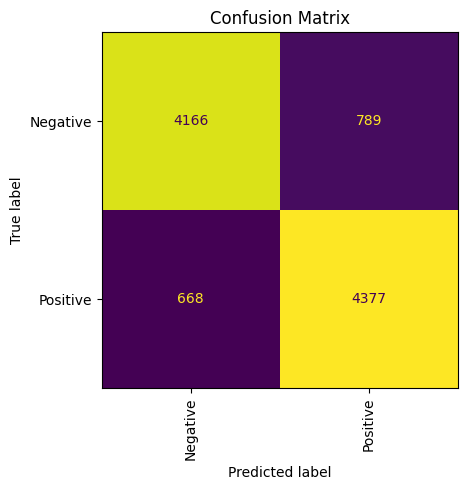

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(test["Polarity"], predicts, ax=ax, colorbar=False)
ax.xaxis.set_tick_params(rotation=90)
_ = ax.set_title("Confusion Matrix")
plt.tight_layout()